# IMDB

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

## Preparing the data

In [3]:
path = Path('../data/')

In [9]:
poems = (path/'poems.txt').open().read().split('\n\n\n\n\n\n\n')
poems_df = pd.DataFrame(poems)
poems_df.head()

,0
0,O Captain! my Captain! our fearful trip is don...
1,"This is thy hour O Soul, thy free flight into ..."
2,"This is thy hour O Soul, thy free flight into ..."
3,"A noiseless, patient spider,\nI mark’d, where,..."
4,"A glimpse, through an interstice caught,\nOf a..."


In [13]:
poems_df.iloc[1][0],poems_df.iloc[0][0]

('This is thy hour O Soul, thy free flight into the wordless,\nAway from books, away from art, the day erased, the lesson done,\nThee fully forth emerging, silent, gazing, pondering the themes thou\nlovest best.\nNight, sleep, death and the stars.',
 "O Captain! my Captain! our fearful trip is done;\nThe ship has weather'd every rack, the prize we sought is won;\nThe port is near, the bells I hear, the people all exulting,\nWhile follow eyes the steady keel, the vessel grim and daring:\nBut O heart! heart! heart!\nO the bleeding drops of red,\nWhere on the deck my Captain lies,\nFallen cold and dead.\n\nO Captain! my Captain! rise up and hear the bells;\nRise up--for you the flag is flung--for you the bugle trills; 10\nFor you bouquets and ribbon'd wreaths--for you the shores a-crowding;\nFor you they call, the swaying mass, their eager faces turning;\nHere Captain! dear father!\nThis arm beneath your head;\nIt is some dream that on the deck,\nYou've fallen cold and dead.\n\nMy Captain

In [15]:
bs=48

In [18]:
tokenizer = Tokenizer(SpacyTokenizer, 'en')
processor = [TokenizeProcessor(tokenizer=tokenizer), NumericalizeProcessor(min_freq=1,max_vocab=60000)]
data_lm = (TextList.from_df(poems_df,path,cols=0,processor=processor)
            .split_by_rand_pct(0.1)
            .label_for_lm()           
            .databunch(bs=bs))

In [19]:
data_lm.show_batch()

idx,text
0,"! heart ! \n o the bleeding drops of red , \n xxmaj where on the deck my xxmaj captain lies , \n xxmaj fallen cold and dead . \n \n o xxmaj captain ! my xxmaj captain ! rise up and hear the bells ; \n xxmaj rise up -- for you the flag is flung -- for you the bugle trills ; 10"
1,"answer could be found . \n xxmaj till suddenly one wondrous night . \n xxmaj all in a flash he saw the light . \n xxmaj he jumped up like a ballet dancer \n xxmaj and yelled , "" xxmaj by gum , i 've got the answer ! "" \n "" xxmaj they want my bacon slice by slice \n "" xxmaj to"
2,"in the centre of your room , \n house , half - acre , square mile , island , country , \n knowing at last how you got there , \n and say , i own this , \n \n \n is the same moment when the trees unloose \n their soft arms from around you , \n the birds take back their language"
3,"xxmaj not everything that can be counted counts , \n and not everything that counts can be counted . \n \n \n xxmaj only one who devotes himself \n to a cause \n with his whole strength and soul \n can be a true master . \n xxmaj for this reason mastery \n demands all of a person . \n \n \n"
4,"\n xxmaj blown on the dank , unwholesome breeze , \n xxmaj awoke the never ending sneeze . \n \n \n xxmaj strange pictures decked the arras drear , \n xxmaj strange characters of woe and fear , \n xxmaj the humbugs of the social sphere . \n \n \n xxmaj one showed a vain and noisy prig , \n xxmaj that shouted"


In [20]:
data_lm.save('poems_tmp')

## Language model

In [8]:
defaults.device = 'cpu'

In [21]:
data_lm = load_data(path, 'poems_tmp', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,"! heart ! \n o the bleeding drops of red , \n xxmaj where on the deck my xxmaj captain lies , \n xxmaj fallen cold and dead . \n \n o xxmaj captain ! my xxmaj captain ! rise up and hear the bells ; \n xxmaj rise up -- for you the flag is flung -- for you the bugle trills ; 10"
1,"answer could be found . \n xxmaj till suddenly one wondrous night . \n xxmaj all in a flash he saw the light . \n xxmaj he jumped up like a ballet dancer \n xxmaj and yelled , "" xxmaj by gum , i 've got the answer ! "" \n "" xxmaj they want my bacon slice by slice \n "" xxmaj to"
2,"in the centre of your room , \n house , half - acre , square mile , island , country , \n knowing at last how you got there , \n and say , i own this , \n \n \n is the same moment when the trees unloose \n their soft arms from around you , \n the birds take back their language"
3,"xxmaj not everything that can be counted counts , \n and not everything that counts can be counted . \n \n \n xxmaj only one who devotes himself \n to a cause \n with his whole strength and soul \n can be a true master . \n xxmaj for this reason mastery \n demands all of a person . \n \n \n"
4,"\n xxmaj blown on the dank , unwholesome breeze , \n xxmaj awoke the never ending sneeze . \n \n \n xxmaj strange pictures decked the arras drear , \n xxmaj strange characters of woe and fear , \n xxmaj the humbugs of the social sphere . \n \n \n xxmaj one showed a vain and noisy prig , \n xxmaj that shouted"


In [23]:
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.3)
learn = language_model_learner(data_lm, arch=AWD_LSTM,pretrained_fnames=['gbergsubset_fine_tuned','gutenberg_itos'], drop_mult=0.3)

In [14]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


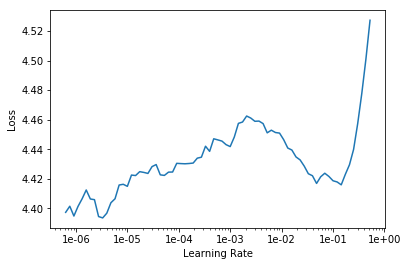

In [15]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.519135,4.012022,0.312314,00:09


In [25]:
learn.save('poems_fit_head')

In [20]:
learn.load('poems_fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.991382,3.954212,0.316890,00:11
1,3.939799,3.942488,0.318750,00:11
2,3.689169,3.930336,0.324442,00:11
3,3.467126,3.950777,0.330729,00:11
4,3.048700,3.926446,0.338393,00:11
5,2.762334,3.979816,0.341741,00:11
6,2.494223,4.026433,0.344159,00:11
7,2.299362,4.077821,0.345573,00:11
8,2.231355,4.090702,0.346019,00:11
9,2.131160,4.093945,0.346094,00:11


In [63]:
math.exp(3.804315)

44.89448685430502

In [28]:
learn.save('poems_fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [12]:
learn.load('poems_fine_tuned');

In [41]:
TEXT = "O captain my captain"
N_WORDS = 100
N_SENTENCES = 1

In [25]:
learn.predi

In [32]:
b = data_lm.valid_ds.x.get(0)

In [14]:
valid_text = []
for i in range(len(data_lm.valid_ds)):
    valid_text.append(data_lm.valid_ds.x.get(i).text)

In [10]:
valid_text[1]

"xxbos xxmaj the very spirit of summer breathes to - day , \n xxmaj here where i sun me in a dreamy mood , \n xxmaj and laps the sultry xxunk , and seems to brood \n xxmaj tenderly o'er those xxunk hills far away . \n xxmaj the air is fragrant with the new - xxunk hay , \n xxmaj and xxunk with hum of myriad flies pursued \n xxmaj by xxunk xxunk . xxmaj all yon xxunk wood \n xxmaj is drowned in sunshine till its green looks grey . \n xxmaj no xxunk of cloud is in the still blue sky , \n xxmaj xxunk with heat , from which the xxunk trees \n xxmaj stand out -- each leaf cut sharp . xxmaj the xxunk scythe \n xxmaj makes xxunk music for me as i lie , \n xxmaj watching the xxunk of the children xxunk , \n xxmaj drinking the season 's sweetness to the xxunk ."

In [50]:
len(text)

748

In [15]:
test = [valid_text[1],valid_text[4],valid_text[5]]
test

["xxbos xxmaj the very spirit of summer breathes to - day , \n xxmaj here where i sun me in a dreamy mood , \n xxmaj and laps the sultry xxunk , and seems to brood \n xxmaj tenderly o'er those xxunk hills far away . \n xxmaj the air is fragrant with the new - xxunk hay , \n xxmaj and xxunk with hum of myriad flies pursued \n xxmaj by xxunk xxunk . xxmaj all yon xxunk wood \n xxmaj is drowned in sunshine till its green looks grey . \n xxmaj no xxunk of cloud is in the still blue sky , \n xxmaj xxunk with heat , from which the xxunk trees \n xxmaj stand out -- each leaf cut sharp . xxmaj the xxunk scythe \n xxmaj makes xxunk music for me as i lie , \n xxmaj watching the xxunk of the children xxunk , \n xxmaj drinking the season 's sweetness to the xxunk .",
 "xxbos \n\n xxup see , dear , what thy lover brings ; \n ' xxmaj tis the flower with the white wings . \n xxmaj xxunk upon the quiet stream \n xxmaj in the spring it lay xxunk . \n\n\n xxmaj xxunk to bestow this guest , \n xxmaj lodg

In [17]:
import string
def post_process(text):
    #text = text.replace('\n','\\n')
    text = text.split()
    new_text = ''
    for i in range(len(text)):
        if text[i] in ['xxmaj','xxup'] and i+1<len(text): text[i+1] = text[i+1].capitalize()
        if text[i] == 'i': text[i] = text[i].capitalize()
    for tok in text:
        if tok in string.punctuation or tok in ["\'m","n\'t","\'ll"]:new_text+=tok
        elif tok not in ['xxmaj','xxup','xxbos']:new_text+=' '+tok
    return new_text.replace('\\n','\n').replace('" ','"')

In [19]:
seed = test[0].split(' ')
seed

['xxbos',
 'xxmaj',
 'the',
 'very',
 'spirit',
 'of',
 'summer',
 'breathes',
 'to',
 '-',
 'day',
 ',',
 '\n',
 'xxmaj',
 'here',
 'where',
 'i',
 'sun',
 'me',
 'in',
 'a',
 'dreamy',
 'mood',
 ',',
 '\n',
 'xxmaj',
 'and',
 'laps',
 'the',
 'sultry',
 'xxunk',
 ',',
 'and',
 'seems',
 'to',
 'brood',
 '\n',
 'xxmaj',
 'tenderly',
 "o'er",
 'those',
 'xxunk',
 'hills',
 'far',
 'away',
 '.',
 '\n',
 'xxmaj',
 'the',
 'air',
 'is',
 'fragrant',
 'with',
 'the',
 'new',
 '-',
 'xxunk',
 'hay',
 ',',
 '\n',
 'xxmaj',
 'and',
 'xxunk',
 'with',
 'hum',
 'of',
 'myriad',
 'flies',
 'pursued',
 '\n',
 'xxmaj',
 'by',
 'xxunk',
 'xxunk',
 '.',
 'xxmaj',
 'all',
 'yon',
 'xxunk',
 'wood',
 '\n',
 'xxmaj',
 'is',
 'drowned',
 'in',
 'sunshine',
 'till',
 'its',
 'green',
 'looks',
 'grey',
 '.',
 '\n',
 'xxmaj',
 'no',
 'xxunk',
 'of',
 'cloud',
 'is',
 'in',
 'the',
 'still',
 'blue',
 'sky',
 ',',
 '\n',
 'xxmaj',
 'xxunk',
 'with',
 'heat',
 ',',
 'from',
 'which',
 'the',
 'xxunk',
 'tre

In [22]:
preds = []
for text in test:
    seed = text.split(' ')
    num_words = len(seed)
    seed = ' '.join(t for t in seed[:len(seed)//4])
    preds.append(learn.predict(seed,num_words))

In [23]:
for pred in preds:
    print('-------poem start-------')
    print(post_process(pred))
    print('-------poem end---------')

-------poem start-------
 The very spirit of summer breathes to- day, 
 Here where I sun me in a dreamy mood, 
 And laps the sultry xxunk, and seems to brood 
 Tenderly o'er the city life and time. 


 But the busy valley din with bent wings, 
 Comes still closer to the flash of the lightning toward the sky, the sky 's sombre grave,& the pale rainbow 's glare runs over everything. 

 Among all the brave and brave men in America, 
 Dome- On- Shore, 
 o Captain Sunrise, 
 They fill the very place of mine hate, 
 Where I those days beheld the entered spout 
 Of the sea of men and beneath which your glittering feet are plucked; 
 Across the goblet of gentle love, how sleep it seems, 
 Sleep- breathing like a rich dying dream! 


 Fifty long years from the death, 
 Not one of the many who can be seen in
-------poem end---------
-------poem start-------
 

 See, dear, what thy lover brings; 
' Tis the flower with the white wings. 
 Xxunk upon the quiet stream 
 In the spring it lay xxunk -- 

In [11]:
text = valid_text[4]
text = text.split()
text, len(text)

(['xxbos',
  'xxup',
  'see',
  ',',
  'dear',
  ',',
  'what',
  'thy',
  'lover',
  'brings',
  ';',
  "'",
  'xxmaj',
  'tis',
  'the',
  'flower',
  'with',
  'the',
  'white',
  'wings',
  '.',
  'xxmaj',
  'xxunk',
  'upon',
  'the',
  'quiet',
  'stream',
  'xxmaj',
  'in',
  'the',
  'spring',
  'it',
  'lay',
  'xxunk',
  '.',
  'xxmaj',
  'xxunk',
  'to',
  'bestow',
  'this',
  'guest',
  ',',
  'xxmaj',
  'lodge',
  'it',
  ',',
  'dear',
  'one',
  ',',
  'in',
  'thy',
  'breast',
  ';',
  'xxmaj',
  'there',
  'its',
  'leaves',
  'the',
  'secret',
  'keep',
  'xxmaj',
  'of',
  'a',
  'wave',
  'both',
  'still',
  'and',
  'deep',
  '.',
  'xxmaj',
  'child',
  ',',
  'beware',
  'the',
  'xxunk',
  '-',
  'fed',
  'stream',
  ';',
  'xxmaj',
  'danger',
  ',',
  'danger',
  ',',
  'there',
  'to',
  'dream',
  '!',
  'xxmaj',
  'though',
  'the',
  'sprite',
  'xxunk',
  'to',
  'sleep',
  ',',
  'xxmaj',
  'and',
  'above',
  'the',
  'lilies',
  'xxunk',
  '.',
  '

In [15]:
#seed = ' '.join(o for o in text[:len(valid[4])//4])
#seed = 'xxbos \n\n xxmaj these are ashes of treasures : \n xxmaj of hurt and loss . \n xxmaj these are ashes in face of which \n xxmaj granite is dross . \n xxmaj dove , naked and brilliant'
valid_text[4][:len(valid_text[4])//4],len(text),len(valid_text[4])

("xxbos \n\n xxup see , dear , what thy lover brings ; \n ' xxmaj tis the flower with the white wings . \n xxmaj xxunk upon the quiet stream \n xxmaj in the spring it lay xxunk",
 136,
 677)

In [32]:
learn.predict(valid_text[5][:175],len(text))

"xxbos \n\n xxmaj these are ashes of treasures : \n xxmaj of hurt and loss . \n xxmaj these are ashes in face of which \n xxmaj granite is dross . \n xxmaj dove , naked and brilliant \n  xxmaj is the perfection that is mournfully \n\n\n xxmaj or end . \n xxmaj let us look at the sky , and see if there \n  xxmaj is nothing for it but a sky . ' \n\n\n xxmaj give me bitten \n xxmaj by the xxmaj mouth of the xxmaj gaping xxmaj bird . ' \n\n\n xxmaj mary ; -- \n\n\n\n xxmaj childhood . \n\n\n\n you step on the xxmaj step , eyes of xxmaj true \n  xxmaj rest do you not xxmaj give to xxmaj faith , xxmaj dreams joys for you ? , rest with your hands \n  xxmaj and rest xxmaj your flower upon your xxmaj breast . xxmaj rest yourself after your rest , for even if your eyes ( the lips ? ) are but a wooden xxmaj rod of"

In [20]:
learn.predict(seed,len(text))

"xxbos xxmaj let us sit by a xxunk steam xxunk a winter 's day , gray wind xxunk frozen xxunk on the window , xxmaj and let us talk about milk wagon xxunk and xxunk xxunk boys . xxmaj let us keep our feet in the warm in order to wash the milk . \n xxmaj little xxmaj white - xxmaj flakes of fifty pounds of flour and some of anything is bitter stout . \n xxmaj we must dig for mines in stone and stone , antique pine , chalk and found in stones . \n xxmaj we seek all by xxmaj fire - river , and lose our way over xxmaj channel by a xxmaj sail , by the white laughter of the xxmaj light - xxmaj truth . xxbos \n\n xxmaj love is enough : the truth is whole : \n xxmaj and this is what we are all brothers which ought \n xxmaj to love each other , all hearts wise . \n\n\n xxmaj but what is evil ; we love all \n  xxmaj our love and looks for we are to live , \n xxmaj we handle it as a gift and a glory , \n xxmaj and our body is a gift , a gift , a gift . \n\n\n xxmaj we want the best and most cloud

In [16]:
learn.predict(valid_text[4][:len(valid_text[4])//4],136)

"xxbos \n\n xxup see , dear , what thy lover brings ; \n ' xxmaj tis the flower with the white wings . \n xxmaj xxunk upon the quiet stream \n xxmaj in the spring it lay xxunk xxmaj holy xxmaj moving 's band . \n\n\n xxmaj soul that sees the perfume and brooded so , \n  xxmaj the spirit thinks the fruit is as its wing and the skies are full of it . \n xxmaj tore from strife , the cup the fairest flies , \n xxmaj the although the soul itself shows there is nothing before them . xxbos \n\n xxmaj the music that told me \n of sultry heat , \n  xxmaj cheerful you , \n xxmaj arose from hours to hour , \n xxmaj birds that come and go ; \n xxmaj moon , stars that never rose , \n  xxmaj seemed to me like fragrance ; \n  xxmaj there was light and purple cheek , \n xxmaj and beauty of these everything i said \n  taught me ;"

In [39]:
preds = []
for text in valid_text:
    preds.append(learn.predict(text[:len(text)//4],len(text)))

In [40]:
valid_text[0], preds[0]

("xxbos \n\n xxmaj to what serves mortal beauty ' xxunk ; does set xxunk \n ing blood — the o - seal - that - so ' feature , flung xxunk form \n xxmaj than xxmaj xxunk tune lets tread to ? ' xxmaj see : it does this : keeps warm \n xxmaj men ’s wits to the things that are ; ' what good means — where a glance \n xxmaj master more may than gaze , ' gaze out of countenance . \n xxmaj those lovely xxunk once , wet - fresh ' xxunk of war ’s storm , \n xxmaj how then should xxmaj xxunk , a father , ' have xxunk else from xxunk \n xxunk xxmaj rome ? xxmaj but xxmaj god to a nation ' dealt that day ’s dear chance . \n xxmaj to man , that needs would worship ' xxunk or barren stone , \n xxmaj our law says : xxmaj love what are ' love ’s xxunk , were all known ; \n xxmaj world ’s loveliest — men ’s xxunk . xxmaj self ' flashes off frame and face . \n xxmaj what do then ? how meet beauty ? ' xxmaj merely meet it ; own , \n xxmaj home at heart , heaven ’s sweet gift ; ' then leave , let that alone

In [ ]:
with open(path/'valid_preds.txt','w') as f:
    for i in range(len(preds)):
        f.write(valid_text[i]+'\n\n\n\n'+preds[i]++'\n\n\n\n\n\n\n')

In [43]:
print("\n".join(learn.predict(TEXT, N_WORDS, no_unk=False) for _ in range(N_SENTENCES)))

O captain my captain is now gay . sea , the last of the sky is mine . xxmaj take none . xxmaj oh no ! " xxmaj oh well , there is no lesson or kind . " xxbos xxmaj one day when he was scared while watching the hours 
 xxmaj fall of dry time . xxmaj ghost 
 xxmaj try , close - up in the hot weather , 
 xxmaj see how i was struck , 
 xxmaj and what would be wrong for artist artist to have hands 
 a light for light eyes or a smile on my


We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [27]:
learn.save_encoder('poems_fine_tuned_enc')

In [11]:
preds = learn.pred_batch(data_lm.valid_ds)

In [24]:
learn.get_preds(data_lm.valid_ds)

[tensor([[7.2770e-03, 5.4183e-09, 8.2082e-06,  ..., 3.6127e-06, 2.1185e-06,
          1.5983e-06],
         [4.0108e-03, 3.4691e-10, 1.2907e-07,  ..., 4.3498e-08, 4.2136e-08,
          6.2436e-07],
         [1.3981e-02, 3.7564e-09, 7.3971e-05,  ..., 5.6119e-07, 6.6024e-07,
          3.9260e-06],
         ...,
         [2.0507e-03, 5.3355e-10, 2.5726e-07,  ..., 3.0511e-07, 3.3347e-07,
          4.7480e-07],
         [4.3454e-01, 4.2099e-09, 3.2343e-05,  ..., 4.9641e-06, 3.8613e-06,
          3.3842e-06],
         [8.5676e-03, 1.9938e-09, 3.5573e-06,  ..., 1.5093e-06, 1.3036e-06,
          1.6957e-07]]), tensor([[ 147,    4,   53,  ...,   27,  106,   10],
         [   4,   56,    0,  ...,    4,  574,  189],
         [1043,   18,   12,  ..., 6256, 5214,  322],
         ...,
         [   4,    4,   10,  ...,    8,   11,  122],
         [2837, 2354,  226,  ...,    4, 2022,   60],
         [  21,  491,   13,  ...,   33, 1391,   83]])]

In [17]:
valid_x = data_lm.valid_ds.x

In [23]:
valid_x.items

array([array([  2,  27,   4,  14, ..., 140,   9, 478,  12]), array([  2,   4,  10, 371, ...,  14,  10,   0,  12]),
       array([  2, 119,   5, 344, ...,  82,  33,  43,  26]), array([  2,   4, 125, 113, ...,  16,  10, 106,  12]), ...,
       array([   2,   27,    4, 3102, ...,   74,  797, 4737,   50]),
       array([  2,  27,   4,  29, ..., 200,  10, 245,  12]), array([2]),
       array([   2,   27,    4,   49, ...,   15, 1655, 3043,   12])], dtype=object)